In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import getcwd
import numpy as np
from importlib import reload
import cv2

In [2]:
from sklearn.decomposition import PCA

In [3]:
import utils
reload(utils)

Using TensorFlow backend.


<module 'utils' from 'C:\\Users\\Smit\\ds5230_2020_project\\utils.py'>

In [4]:
PROJECT_PATH = getcwd()
PICKLE_PATH = PROJECT_PATH + "\\pickles\\"

# Loading Train Images

In [5]:
train_images = utils.open_pickle(file = PICKLE_PATH + "train_images" )

In [6]:
IMG_DIMENSION = train_images[0].shape
IMG_DIMENSION

(80, 60, 3)

In [7]:
train_images = train_images.reshape((train_images.shape[0], IMG_DIMENSION[0]*IMG_DIMENSION[1]*IMG_DIMENSION[2]))
train_images = train_images/255.0 # normalizing image

In [8]:
print("Total images: %d"%train_images.shape[0])
print("Dimension of image before PCA Transformation: %d"%train_images.shape[1])

Total images: 10796
Dimension of image before PCA Transformation: 14400


# Performing PCA on images

In [9]:
N_PCA_COMPONENTS = 1000
pca = PCA(n_components=N_PCA_COMPONENTS, random_state=40)

In [10]:
%%time
pca_fit = pca.fit(train_images)

Wall time: 2min 3s


In [11]:
print("Total variance (out of 1) captured by", 
      N_PCA_COMPONENTS,
      "components =", round(np.sum(pca.explained_variance_ratio_),3))

Total variance (out of 1) captured by 1000 components = 0.98


In [12]:
cummu_variance_explained = []
CUMMUL_VAR_THRESHOLD = .90
MAX_PCA_COMPONENTS = 0

for i in range(N_PCA_COMPONENTS):
    if i ==0: cummu_variance_explained.append(pca.explained_variance_ratio_[i])
    else: cummu_variance_explained.append(cummu_variance_explained[i-1] + pca.explained_variance_ratio_[i])


for i, var in enumerate(cummu_variance_explained):
    if var >= CUMMUL_VAR_THRESHOLD:
        MAX_PCA_COMPONENTS = i
        break

In [13]:
print("Max number of PCA components required to explain " + \
      str(round(cummu_variance_explained[MAX_PCA_COMPONENTS]*100,2)) + \
      " %variance: " + str(MAX_PCA_COMPONENTS))

Max number of PCA components required to explain 90.01 %variance: 145


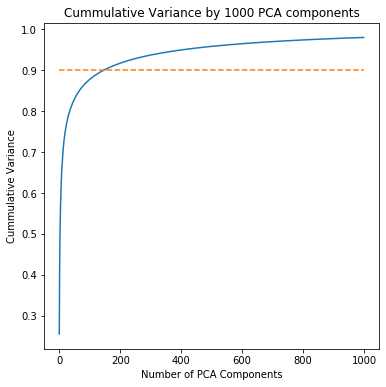

In [14]:
plt.figure(figsize = (6,6))
plt.plot([i for i in range(N_PCA_COMPONENTS)], [i for i in cummu_variance_explained], linestyle="solid")
plt.plot([i for i in range(N_PCA_COMPONENTS)], [CUMMUL_VAR_THRESHOLD]*len(pca.explained_variance_ratio_), linestyle="dashed")
fig_name = "Cummulative Variance by " + str(N_PCA_COMPONENTS)+ " PCA components"
plt.xlabel("Number of PCA Components")
plt.ylabel("Cummulative Variance")
plt.title(fig_name)
plt.savefig(".\\Outputs\\" + fig_name + ".png")

In [15]:
print("We will consider first %d components to tranform images"%MAX_PCA_COMPONENTS)

We will consider first 145 components to tranform images


In [16]:
%%time
pca = PCA(n_components=MAX_PCA_COMPONENTS, random_state=40)
pca_fit = pca.fit(train_images)

Wall time: 27.4 s


In [17]:
# transforming images into lower dimension
transformed_images = pca_fit.transform(train_images)

In [18]:
print("Dimension of image after PCA Transformation: %d"%transformed_images.shape[1])

Dimension of image after PCA Transformation: 145


In [19]:
# to get original image shape after dropping non-essential components
inv_transf_images = pca_fit.inverse_transform(transformed_images)

In [20]:
inv_transf_images.shape

(10796, 14400)

# Comparing images before and after transformation

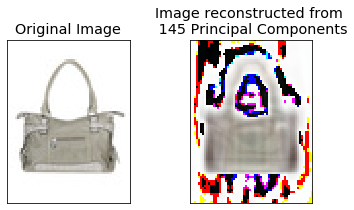

In [51]:
random_image_idx = 100
orig_img = train_images[random_image_idx]*255.0 
orig_img = orig_img.reshape(IMG_DIMENSION).astype('uint8')
inv_transf_img = inv_transf_images[random_image_idx]*255.0 
inv_transf_img = inv_transf_img.reshape(IMG_DIMENSION).astype('uint8')
ax = utils.plot_images([orig_img, inv_transf_img], figsize = (6,3), ncols = 2, axis_style = 'on')
ax[0].set_title("Original Image", {'fontsize': 'x-large'})
ax[1].set_title("Image reconstructed from \n 145 Principal Components", {'fontsize': 'x-large'})
plt.savefig("Outputs/PCA_inv_tranf_img.jpg", bbox_inches='tight')
plt.show()

# 2-D PCA plot using Top 2 PCA components

In [22]:
train_images_idx = utils.open_pickle(file = PICKLE_PATH + "train_images_names")

In [23]:
top_2_components = pd.DataFrame({'component 1': transformed_images[:,0], 
                                 'component 2': transformed_images[:,1]})
top_2_components['idx'] =  train_images_idx 
styles = pd.read_csv('styles.csv', error_bad_lines = False)
styles = styles[['id', 'subCategory']]
top_2_components = pd.merge(top_2_components, styles, left_on='idx', right_on='id', how='left')
top_2_components = top_2_components[['component 1', 'component 2', 'subCategory']]

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

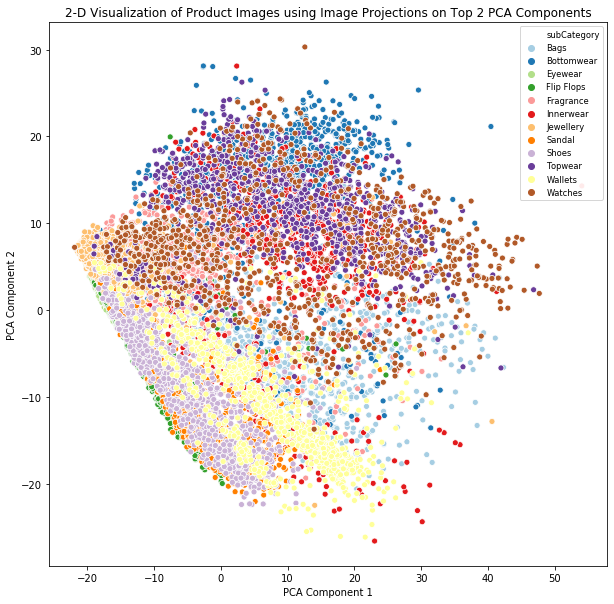

In [24]:
plt.subplots(figsize = (10,10))
palette = sns.color_palette("Paired", len(set(top_2_components['subCategory'])))
sns.scatterplot(x = 'component 1',
                y = 'component 2',
                hue = 'subCategory', 
                data = top_2_components, 
                palette=palette)
fig_name = "2-D Visualization of Product Images using Image Projections on Top 2 PCA Components"
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(fig_name)
plt.legend(fontsize="small", loc="upper right")
plt.savefig(".\\Outputs\\" + fig_name + ".png")

From above visualization we can see that 2-D visualizations using top 2-PCA components is not intuitive to visualize clusters

# Saving fitted PCA object and maximum required PCA components

In [25]:
utils.save_pickle(PICKLE_PATH + "pca_fit_%s_components"%str(MAX_PCA_COMPONENTS), pca_fit)

Variable successfully saved in C:\Users\Smit\ds5230_2020_project\pickles\pca_fit_145_components.pickle


In [26]:
try:
    optimal_metrics = utils.open_pickle(PICKLE_PATH + "optimal_metrics")
except: 
    optimal_metrics = {'MAX_PCA_COMPONENTS': MAX_PCA_COMPONENTS}
    
optimal_metrics['MAX_PCA_COMPONENTS'] = MAX_PCA_COMPONENTS
utils.save_pickle(PICKLE_PATH + "optimal_metrics", optimal_metrics)

Variable successfully saved in C:\Users\Smit\ds5230_2020_project\pickles\optimal_metrics.pickle
